This notebook will show how to roughly recreate the GD394 result from https://ui.adsabs.harvard.edu/abs/2020ApJ...897L..31W/abstract.

In [8]:
#first import some python packages that we need

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

First search for the data

In [77]:
search_result = lk.search_lightcurve('GD 394')
search_result


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,259773610,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,259773610,0.0
2,TESS Sector 15,2019,QLP,1800,259773610,0.0
3,TESS Sector 16,2019,SPOC,120,259773610,0.0
4,TESS Sector 16,2019,TESS-SPOC,1800,259773610,0.0
5,TESS Sector 16,2019,QLP,1800,259773610,0.0


The results show that it was obseved by TESS in Sectors 15 and 16, at 30min and 2min cadence. To keep it simple I'm only going to look at the 2min data from Sector 16, row 3.

In [78]:
lc = search_result[3].download(download_dir='data/') 

"lc" is now our lightcurve object. Let's see what it looks like.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

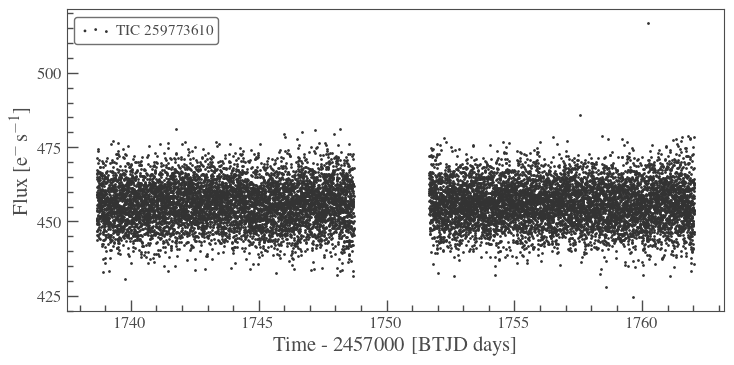

In [79]:
lc.scatter()

Doesn't look like much, but small variations can be hidden in the scatter. First let's divide out the median, as we're only interested in the changes in flux. The convention for variable white dwarfs is to present it as percentage difference from zero, so we'll make that adjustment as well. Note I've made a new light curve object lcn so I keep the non-normalised light curve in case I want to go back and make changes. 

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

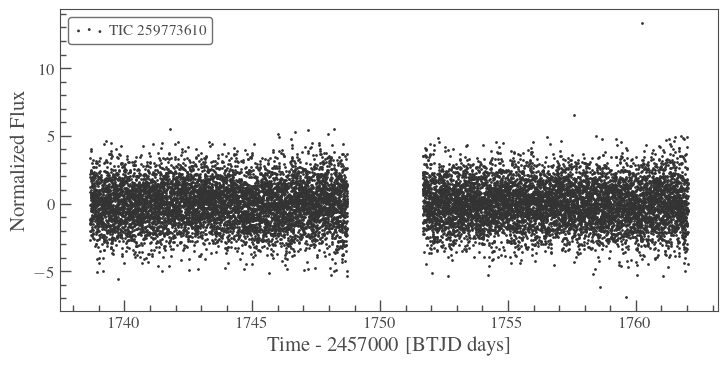

In [80]:
lcn = lc.normalize()
lcn.flux -= 1
lcn.flux *= 100
lcn.flux_err *= 100
lcn.scatter()

Ok, let's look for periods using a Lomb-Scargle periodogram. You can read some of the details [here](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.LombScarglePeriodogram.from_lightcurve.html#lightkurve.periodogram.LombScarglePeriodogram.from_lightcurve), but for options we're using oversample_factor =10 which is a standard value, minimum period = 4 miniutes, the [Nyquist frequency](http://keatonb.github.io/archivers/pyquist) of the data, and a maxium period of 14 days, or roughly the lenghts of one TESS orbit. Note the use of [astropy units](https://docs.astropy.org/en/stable/units/).  

0.5711146792761502 d


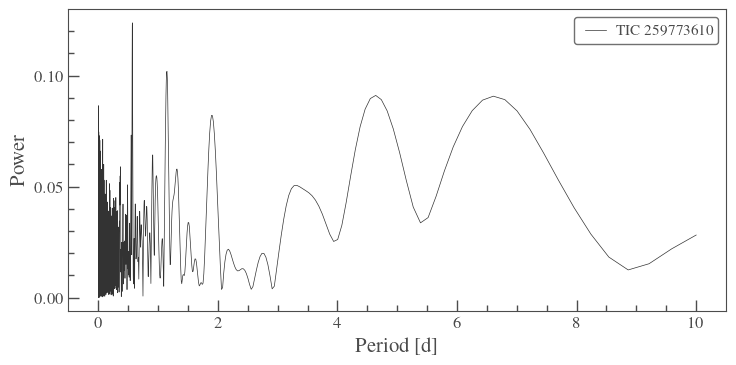

In [81]:
pg = lcn.to_periodogram(oversample_factor=10, minimum_period=4*u.min, maximum_period=10*u.d )
pg.plot()
print(pg.period_at_max_power)

That's a lot of signals. Let's look at the strongest, fold the lightcurve onto that period, and bin to 100 data points. :

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

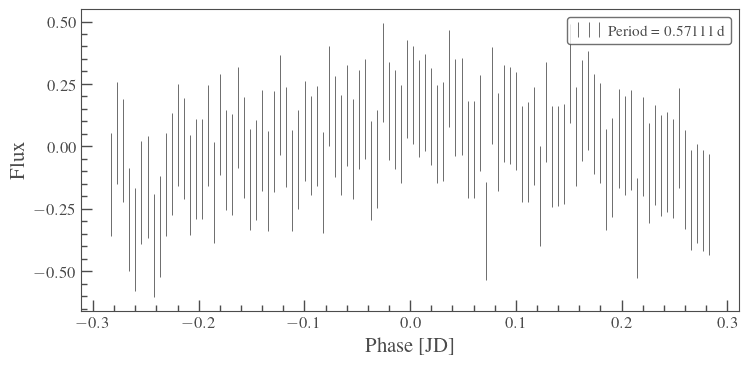

In [82]:
period = pg.period_at_max_power
lcn.fold(period).bin(period/100).errorbar(label=fr'Period = {period.value:.5f} d')

Looks alright? But there are other peaks, and they look like they are harmonics- multiples of the true period. Let's test a few to see which one looks realistic. 

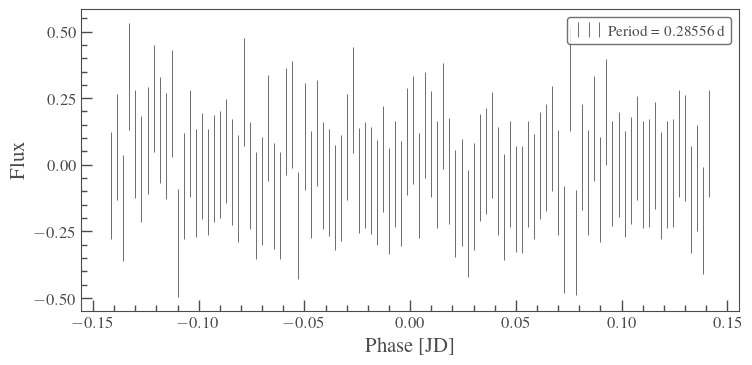

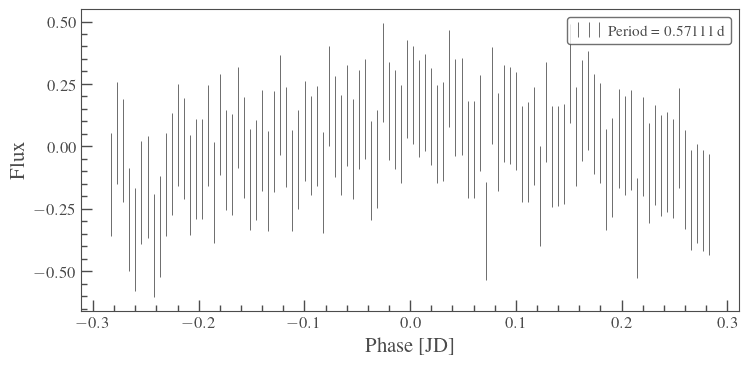

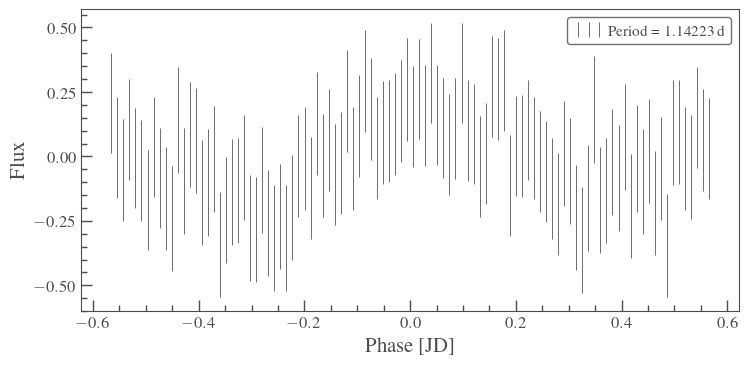

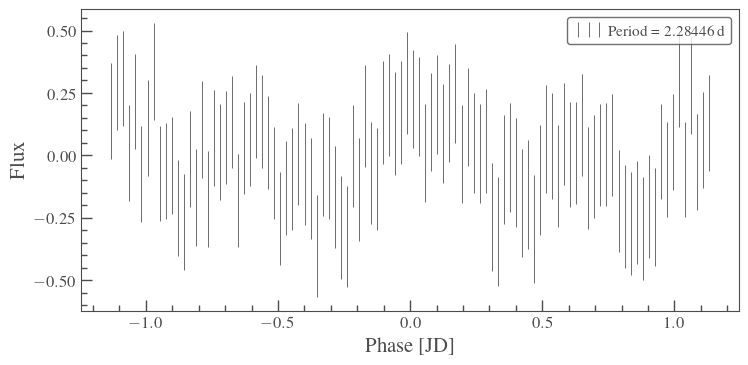

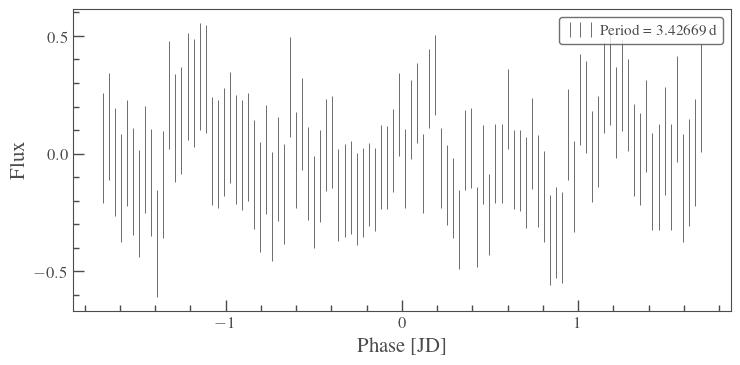

In [83]:
for n in [0.5, 1, 2, 4, 6]:
    period = pg.period_at_max_power*n
    lcn.fold(period).bin(period/100).errorbar(label=fr'Period = {period.value:.5f} d')
    plt.show()

Looks good for the strongest period. So our guess for the period is 0.57 days. But is that right? Try repeating the analysis on the Sector 15 data, and then combine the two sectors together to get a final result.

Why is Sector 15 gappy? Directly downloaded the file from MAST to have a look.

In [14]:
path1 = 'data/MAST_2021-06-15T1214/TESS/tess2019226182529-s0015-0000000259773610-0151-s/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits'
data = fits.getdata(path1, 1)
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']

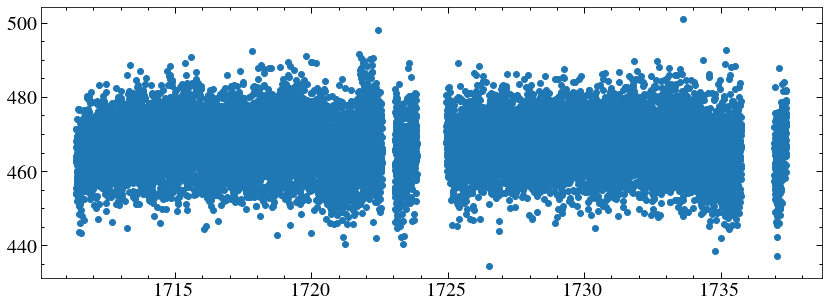

In [15]:
plt.scatter(t, f)

Checking against the original TESS fits files

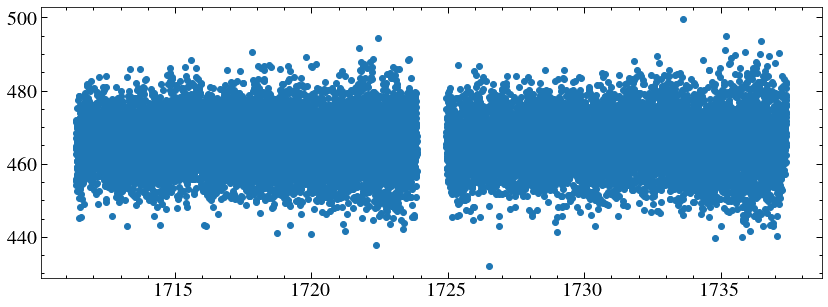

In [16]:
path2 = '/home/david/work/gd394/tess/tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits'
data2 = fits.getdata(path2, 1)
t2, f2, e2, q2 = data2['TIME'], data2['PDCSAP_FLUX'], data2['PDCSAP_FLUX_ERR'], data2['QUALITY']
plt.scatter(t2, f2)

In [18]:
hdr1 = fits.getheader(path1)
hdr2 = fits.getheader(path2)
for key in hdr1:
    if hdr1[key] != hdr2[key]:
        print(key, hdr1[key], hdr2[key])

DATE 2020-04-09 2019-09-23
TSTART 1711.366845043507 1711.358773992636
TSTOP 1737.412957918005 1737.410151544066
DATE-OBS 2019-08-15T20:47:06.228 2019-08-15T20:35:28.889Z
DATE-END 2019-09-10T21:53:30.380 2019-09-10T21:49:27.909Z
CREATOR 20707 LightCurveExporterPipelineModule 14943 LightCurveExporterPipelineModule
PROCVER spoc-4.0.28-20200407 spoc-4.0.9-20190919
DATA_REL 30 21
CHECKSUM Hbr8HZo6Hao6HYo6 eHeehHbZeHbbeHbZ
